# Heart Disease Data

## Table of Contents
- [ Dataset Discription](#0)
- [ 1 - Import Packages](#1)
    - [1.1 Load Data](#1.1)
- [ 2 - Data Wrangling (Preprocessing)](#2)
- [ 3 - Data Cleaning](#3)
- [ 4 - EDA and Visualizations](#4)
- [ 5 - Feature (Importance) Selection](#5)
- [ 6 - Modeling and Evaluation](#6)
  - [ 6.1 Random Forest Classifier](#6.1)
  - [ 6.1.1 Tuned Random Forest Classifier](#6.1.1)
  - [ 6.2 XGBoost Classifier](#6.1)
  - [ 6.2.1 Tuned XGBoost Classifier](#6.1.1)
- [ 7 - Loading Test Data](#7)

<a name="0"></a>
###  Dataset Discription
- Target variable > `HeartDisease`
    - `1` indicates the presence and `0` indicates the absence of these health conditions.
- `ID` an ID for the row
- `Person_Story` A description of the person.
- `Age_Category` categorizes individuals into age groups (e.g., "Senior," "Older," "Middle").
- `BMI` Stands for Body Mass Index and represents a numerical measure of a person's body composition.
- `DiabeticORABS` indicates the presence or absence of diabetes.
- `SkinCancerORABS` indicates the presence or absence of skin cancer.
- `Stroke` indicates whether the person has had a stroke ("Yes" or "No").
- `PhysicalHealth` and `MentalHealth` seem to be measures of physical and mental health.
- `PhysicalActivity` represents whether the person engages in physical activity ("Yes" or "No").
- `DiffWalking` Indicate any difficulties in walking.
- `TimeOfSleep` is Related to the amount of sleep the person gets.
- `Asthma` and "KidneyDisease" indicate the presence or absence of these health conditions.

## Train

<a name="1"></a>
## 1 - Import Packages and Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split ,RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

<a name="1.1"></a>
### 1.1 - Load Data

In [2]:
df = pd.read_csv("/kaggle/input/heart-disease/Data/IEEE_competition.csv")

<a name="2"></a>
## 2 - Data Wrangling (Preprocessing)

### General Properties

In [3]:
df.head()

,ID,Person_Story,Age_Category,BMI,DiabeticORABS,SkinCancerORABS,Stroke,PhysicalHealth,MentalHealth,PhysicalActivity,DiffWalking,TImEOFSLeeP,Asthma,KidneyDisease,HeartDisease
0,0,"Once upon a time, there was a Female person of...",Middle,29.29,Absence,Absence,NaN,0.0,5.0,Yes,NaN,6.0,No,No,Absence
1,1,"Once upon a time, there was a Female person of...",Middle,33.09,Absence,Absence,No,0.0,20.0,Yes,No,9.0,No,No,Absence
2,2,"Once upon a time, there was a Male person of O...",Younger,28.19,Absence,Absence,No,0.0,0.0,Yes,No,7.0,No,No,Absence
3,3,"Once upon a time, there was a Male person of W...",Middle,36.62,Absence,Absence,No,0.0,0.0,No,No,6.0,No,No,Absence
4,4,"Once upon a time, there was a Male person of W...",Middle,33.38,Absence,Absence,Yes,12.0,20.0,No,No,4.0,Yes,No,Absence


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207862 entries, 0 to 207861
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                207862 non-null  int64  
 1   Person_Story      207552 non-null  object 
 2   Age_Category      207552 non-null  object 
 3   BMI               207552 non-null  float64
 4   DiabeticORABS     207552 non-null  object 
 5   SkinCancerORABS   207552 non-null  object 
 6   Stroke            147832 non-null  object 
 7   PhysicalHealth    207552 non-null  float64
 8   MentalHealth      207552 non-null  float64
 9   PhysicalActivity  159410 non-null  object 
 10  DiffWalking       153948 non-null  object 
 11  TImEOFSLeeP       207552 non-null  float64
 12  Asthma            207552 non-null  object 
 13  KidneyDisease     207552 non-null  object 
 14  HeartDisease      207552 non-null  object 
dtypes: float64(4), int64(1), object(10)
memory usage: 23.8+ MB


#### - Some Statisctics for Numeric Columns

In [5]:
df[["BMI", "PhysicalHealth", "MentalHealth", "TImEOFSLeeP"]].describe()

,BMI,PhysicalHealth,MentalHealth,TImEOFSLeeP
count,207552.000000,207552.000000,207552.000000,207552.000000
mean,28.339159,3.375053,3.897857,7.101006
std,6.351421,7.954392,7.957564,1.437473
min,12.020000,0.000000,0.000000,1.000000
25%,24.030000,0.000000,0.000000,6.000000
50%,27.340000,0.000000,0.000000,7.000000
75%,31.460000,2.000000,3.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


In [6]:
df.isna().sum()

ID                      0
Person_Story          310
Age_Category          310
BMI                   310
DiabeticORABS         310
SkinCancerORABS       310
Stroke              60030
PhysicalHealth        310
MentalHealth          310
PhysicalActivity    48452
DiffWalking         53914
TImEOFSLeeP           310
Asthma                310
KidneyDisease         310
HeartDisease          310
dtype: int64

In [7]:
df.duplicated().sum()

0

### Summary
- All columns' types are right, no wrong types
- There is `310` missing values in most of the columns
- There is a lot of missing data in `Stroke`, `Physical Activity` and `DiffWalking`, we need to handle them
- There is no duplicated values
- We can rename column names to be easy for access

<a name="3"></a>
## 3 - Data Cleaning

### - Rename Columns names

In [8]:
df = df.rename(columns = {"DiabeticORABS" : "Diabetic", "SkinCancerORABS" : "Skin_Cancer",
                "PhysicalHealth" : "Physical_Health", "MentalHealth" : "Mental_Health",
               "PhysicalActivity" : "Physical_Activity", "TImEOFSLeeP" : "Time_Of_Sleep",
               "KidneyDisease" : "Kidney_Disease", "HeartDisease" : "Heart_Disease",
               "DiffWalking" : "Diffculty_Walking"})

In [9]:
df.columns

Index(['ID', 'Person_Story', 'Age_Category', 'BMI', 'Diabetic', 'Skin_Cancer',
       'Stroke', 'Physical_Health', 'Mental_Health', 'Physical_Activity',
       'Diffculty_Walking', 'Time_Of_Sleep', 'Asthma', 'Kidney_Disease',
       'Heart_Disease'],
      dtype='object')

### - Dropping missing values

In [10]:
df = df.dropna(subset=['Age_Category'])

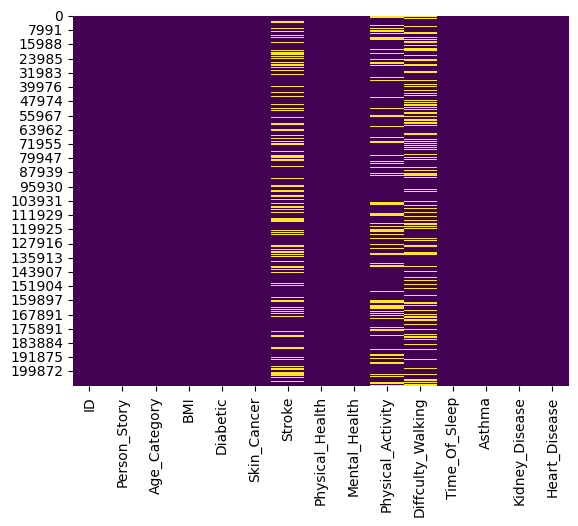

In [11]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show();

### Comment
- We see that missing values in the three columns `Stroke`, `Physical_Activity` and `Difficulty_Walking` are random and of course they are many about 50K in each column
- One of the methods to impute missing values is using other column's values

### Exploring Each Column and Cleaning

### - Clean `Person_Story` Column

In [12]:
for i in range(5):
    print(df["Person_Story"].iloc[i]+ "\n")

Once upon a time, there was a Female person of Black ethnicity. This individual was known for their healthy lifestyle and their abstinence from alcohol. Their general health condition was described as 'Very good'. People often marveled at their unique journey through life.

Once upon a time, there was a Female person of White ethnicity. This individual was known for their smoking habit and their fondness for alcohol. Their general health condition was described as 'Very good'. People often marveled at their unique journey through life.

Once upon a time, there was a Male person of Other ethnicity. This individual was known for their healthy lifestyle and their abstinence from alcohol. Their general health condition was described as 'Good'. People often marveled at their unique journey through life.

Once upon a time, there was a Male person of White ethnicity. This individual was known for their healthy lifestyle and their abstinence from alcohol. Their general health condition was des

#### - Extract some features before droppping

In [13]:
gender_pattern = r'(Male|Female)'
ethnicity_pattern = r'(\w+) ethnicity'
health_condition_pattern = r'general health condition was described as \'([^\']+)\''
lifestyle_pattern = r'known for their (\w+)'
alcohol_habit_pattern = r'(abstinence|fondness)'


df['Gender'] = df['Person_Story'].str.extract(gender_pattern, flags=re.IGNORECASE)
df['Ethnicity'] = df['Person_Story'].str.extract(ethnicity_pattern)
df['General_Health'] = df['Person_Story'].str.extract(health_condition_pattern)
df['Life_Style'] = df['Person_Story'].str.extract(lifestyle_pattern)
df["Alchohol_Habit"] = df['Person_Story'].str.extract(alcohol_habit_pattern)

In [14]:
df = df.drop(columns="Person_Story", axis =1)

In [15]:
for col in df.columns[-5:]:
    print(col + ": "+ str(df[col].unique()))
    print("-------------------------------------------------------------")

Gender: ['Female' 'Male']
-------------------------------------------------------------
Ethnicity: ['Black' 'White' 'Other' 'Hispanic' 'Asian' 'Native']
-------------------------------------------------------------
General_Health: ['Very good' 'Good' 'Fair' 'Poor' 'Excellent']
-------------------------------------------------------------
Life_Style: ['healthy' 'smoking']
-------------------------------------------------------------
Alchohol_Habit: ['abstinence' 'fondness']
-------------------------------------------------------------


In [16]:
for col in df.columns[-5:]:
    print(str(df[col].value_counts()))
    print("-------------------------------------------------------------")

Gender
Female    108850
Male       98702
Name: count, dtype: int64
-------------------------------------------------------------
Ethnicity
White       158915
Hispanic     17895
Black        14977
Other         7102
Asian         5247
Native        3416
Name: count, dtype: int64
-------------------------------------------------------------
General_Health
Very good    73632
Good         60691
Excellent    43355
Fair         22587
Poor          7287
Name: count, dtype: int64
-------------------------------------------------------------
Life_Style
healthy    121786
smoking     85766
Name: count, dtype: int64
-------------------------------------------------------------
Alchohol_Habit
abstinence    193321
fondness       14231
Name: count, dtype: int64
-------------------------------------------------------------


In [17]:
df.isna().sum()

ID                       0
Age_Category             0
BMI                      0
Diabetic                 0
Skin_Cancer              0
Stroke               59720
Physical_Health          0
Mental_Health            0
Physical_Activity    48142
Diffculty_Walking    53604
Time_Of_Sleep            0
Asthma                   0
Kidney_Disease           0
Heart_Disease            0
Gender                   0
Ethnicity                0
General_Health           0
Life_Style               0
Alchohol_Habit           0
dtype: int64

### - Clean `Age_Category` Column

In [18]:
df["Age_Category"].value_counts()

Age_Category
Older      63921
Middle     63648
Younger    50278
Senior     29705
Name: count, dtype: int64

### - Clean `Diabetic` Column

In [19]:
df["Diabetic"].unique()

array(['Absence', 'Presence', 'Yes (during pregnancy)',
       'No, borderline diabetes'], dtype=object)

In [20]:
df["Diabetic"].value_counts()

Diabetic
Absence                    174972
Presence                    26498
No, borderline diabetes      4429
Yes (during pregnancy)       1653
Name: count, dtype: int64

In [21]:
df["Diabetic"] = df["Diabetic"].replace({"Yes (during pregnancy)":"Absence",
                                         "No, borderline diabetes":"Presence"})

### - Filling Missing Values in `Stroke`, `Physical_Activity` and ` Difficulty_Walking`  with values of `Diabetic` Column
    

In [22]:
df["Stroke"] = df["Stroke"].fillna(df['Diabetic'])
df["Physical_Activity"] = df['Physical_Activity'].fillna(df['Diabetic'])
df["Diffculty_Walking"] = df['Diffculty_Walking'].fillna(df['Diabetic'])

df["Stroke"] = df["Stroke"].replace({"Presence":"Yes", "Absence":"No"})
df["Physical_Activity"] = df["Physical_Activity"].replace({"Presence":"Yes", "Absence":"No"})
df["Diffculty_Walking"] = df["Diffculty_Walking"].replace({"Presence":"Yes", "Absence":"No"})

### - Clean `BMI` Column

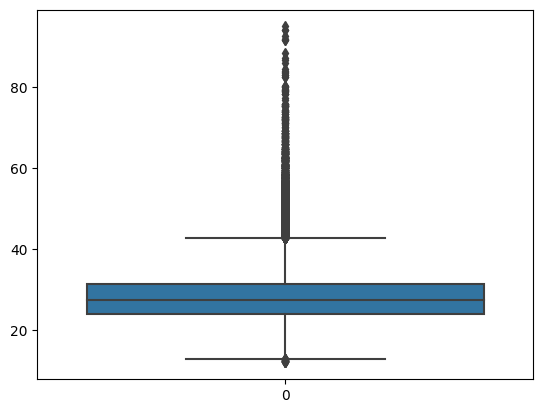

In [23]:
sns.boxplot(data=df["BMI"]);

#### - Dropping Outliers

In [24]:
df = df.drop(df[df["BMI"] > 41].index)
df = df.drop(df[df["BMI"] < 14].index)

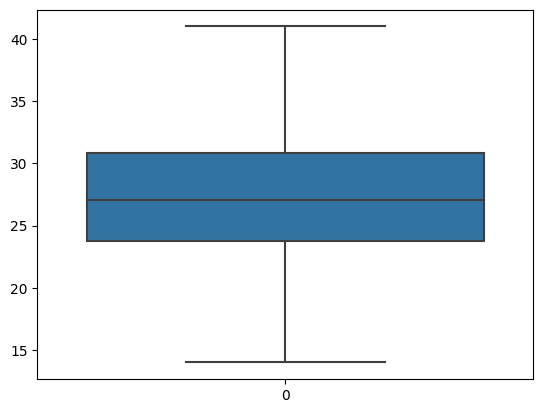

In [25]:
sns.boxplot(data=df["BMI"]);

### - Clean `Time_Of_Sleep` Column

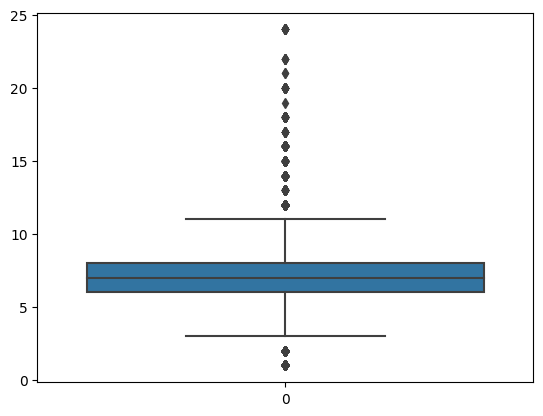

In [26]:
sns.boxplot(data=df["Time_Of_Sleep"]);

#### - Dropping Outliers

In [27]:
df = df.drop(df[df["Time_Of_Sleep"] > 10].index)
df = df.drop(df[df["Time_Of_Sleep"] < 4].index)

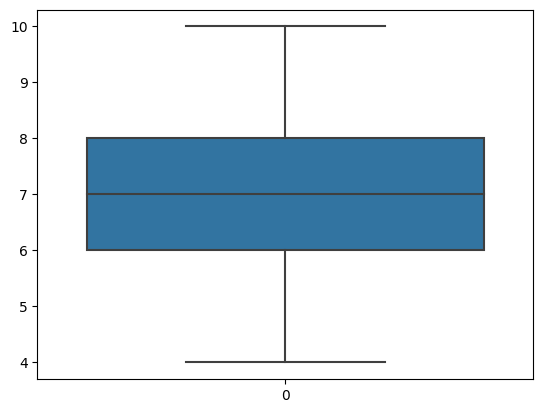

In [28]:
sns.boxplot(data=df["Time_Of_Sleep"]);

### Summary 
- There was some outliers in `BMI` and `Time_Of_Sleep` Columns
- In `Diabetic` Column:
    - `Yes (during pregnancy)` value means that she `is not` Diabetic, so we replaced it with `Absence`
    - `No, borderline diabetes` value means that they are `Diabetic`, so we replaced it with `Presence`

<a name="4"></a>
## 4 - EDA and Visualizations

### - Target Variable Column `Heart Disease`

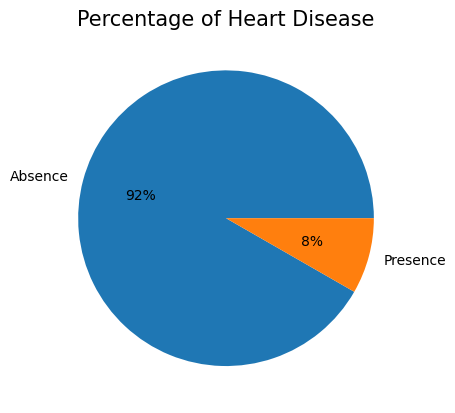

In [29]:
df['Heart_Disease'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Percentage of Heart Disease', fontsize=15)
plt.ylabel('');

### - `Gender` Column

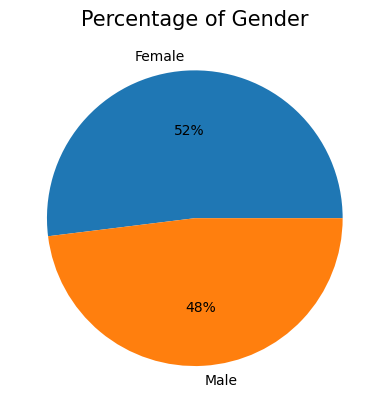

In [30]:
df['Gender'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Percentage of Gender', fontsize=15)
plt.ylabel('');

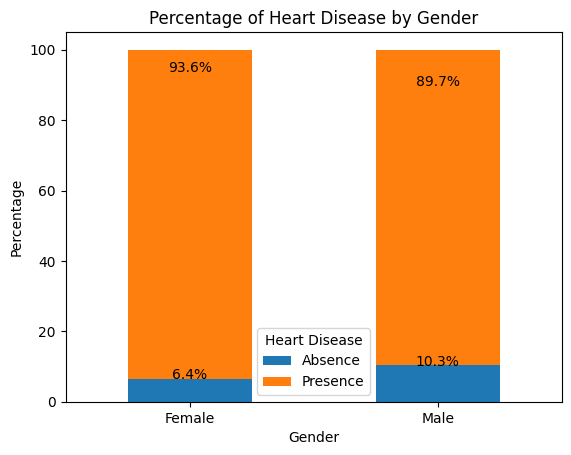

In [31]:
# Create a cross-tabulation (crosstab) to calculate percentages
cross_tab = 100 - (pd.crosstab(df['Gender'], df['Heart_Disease'], normalize='index') * 100)

# Plot the percentages as a stacked bar chart
ax = cross_tab.plot(kind='bar', stacked=True)
plt.title("Percentage of Heart Disease by Gender")
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.legend(title="Heart Disease", loc="best", labels=["Absence", "Presence"])

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2 ,
                                           p.get_height()), ha='center', va='baseline')

plt.show()

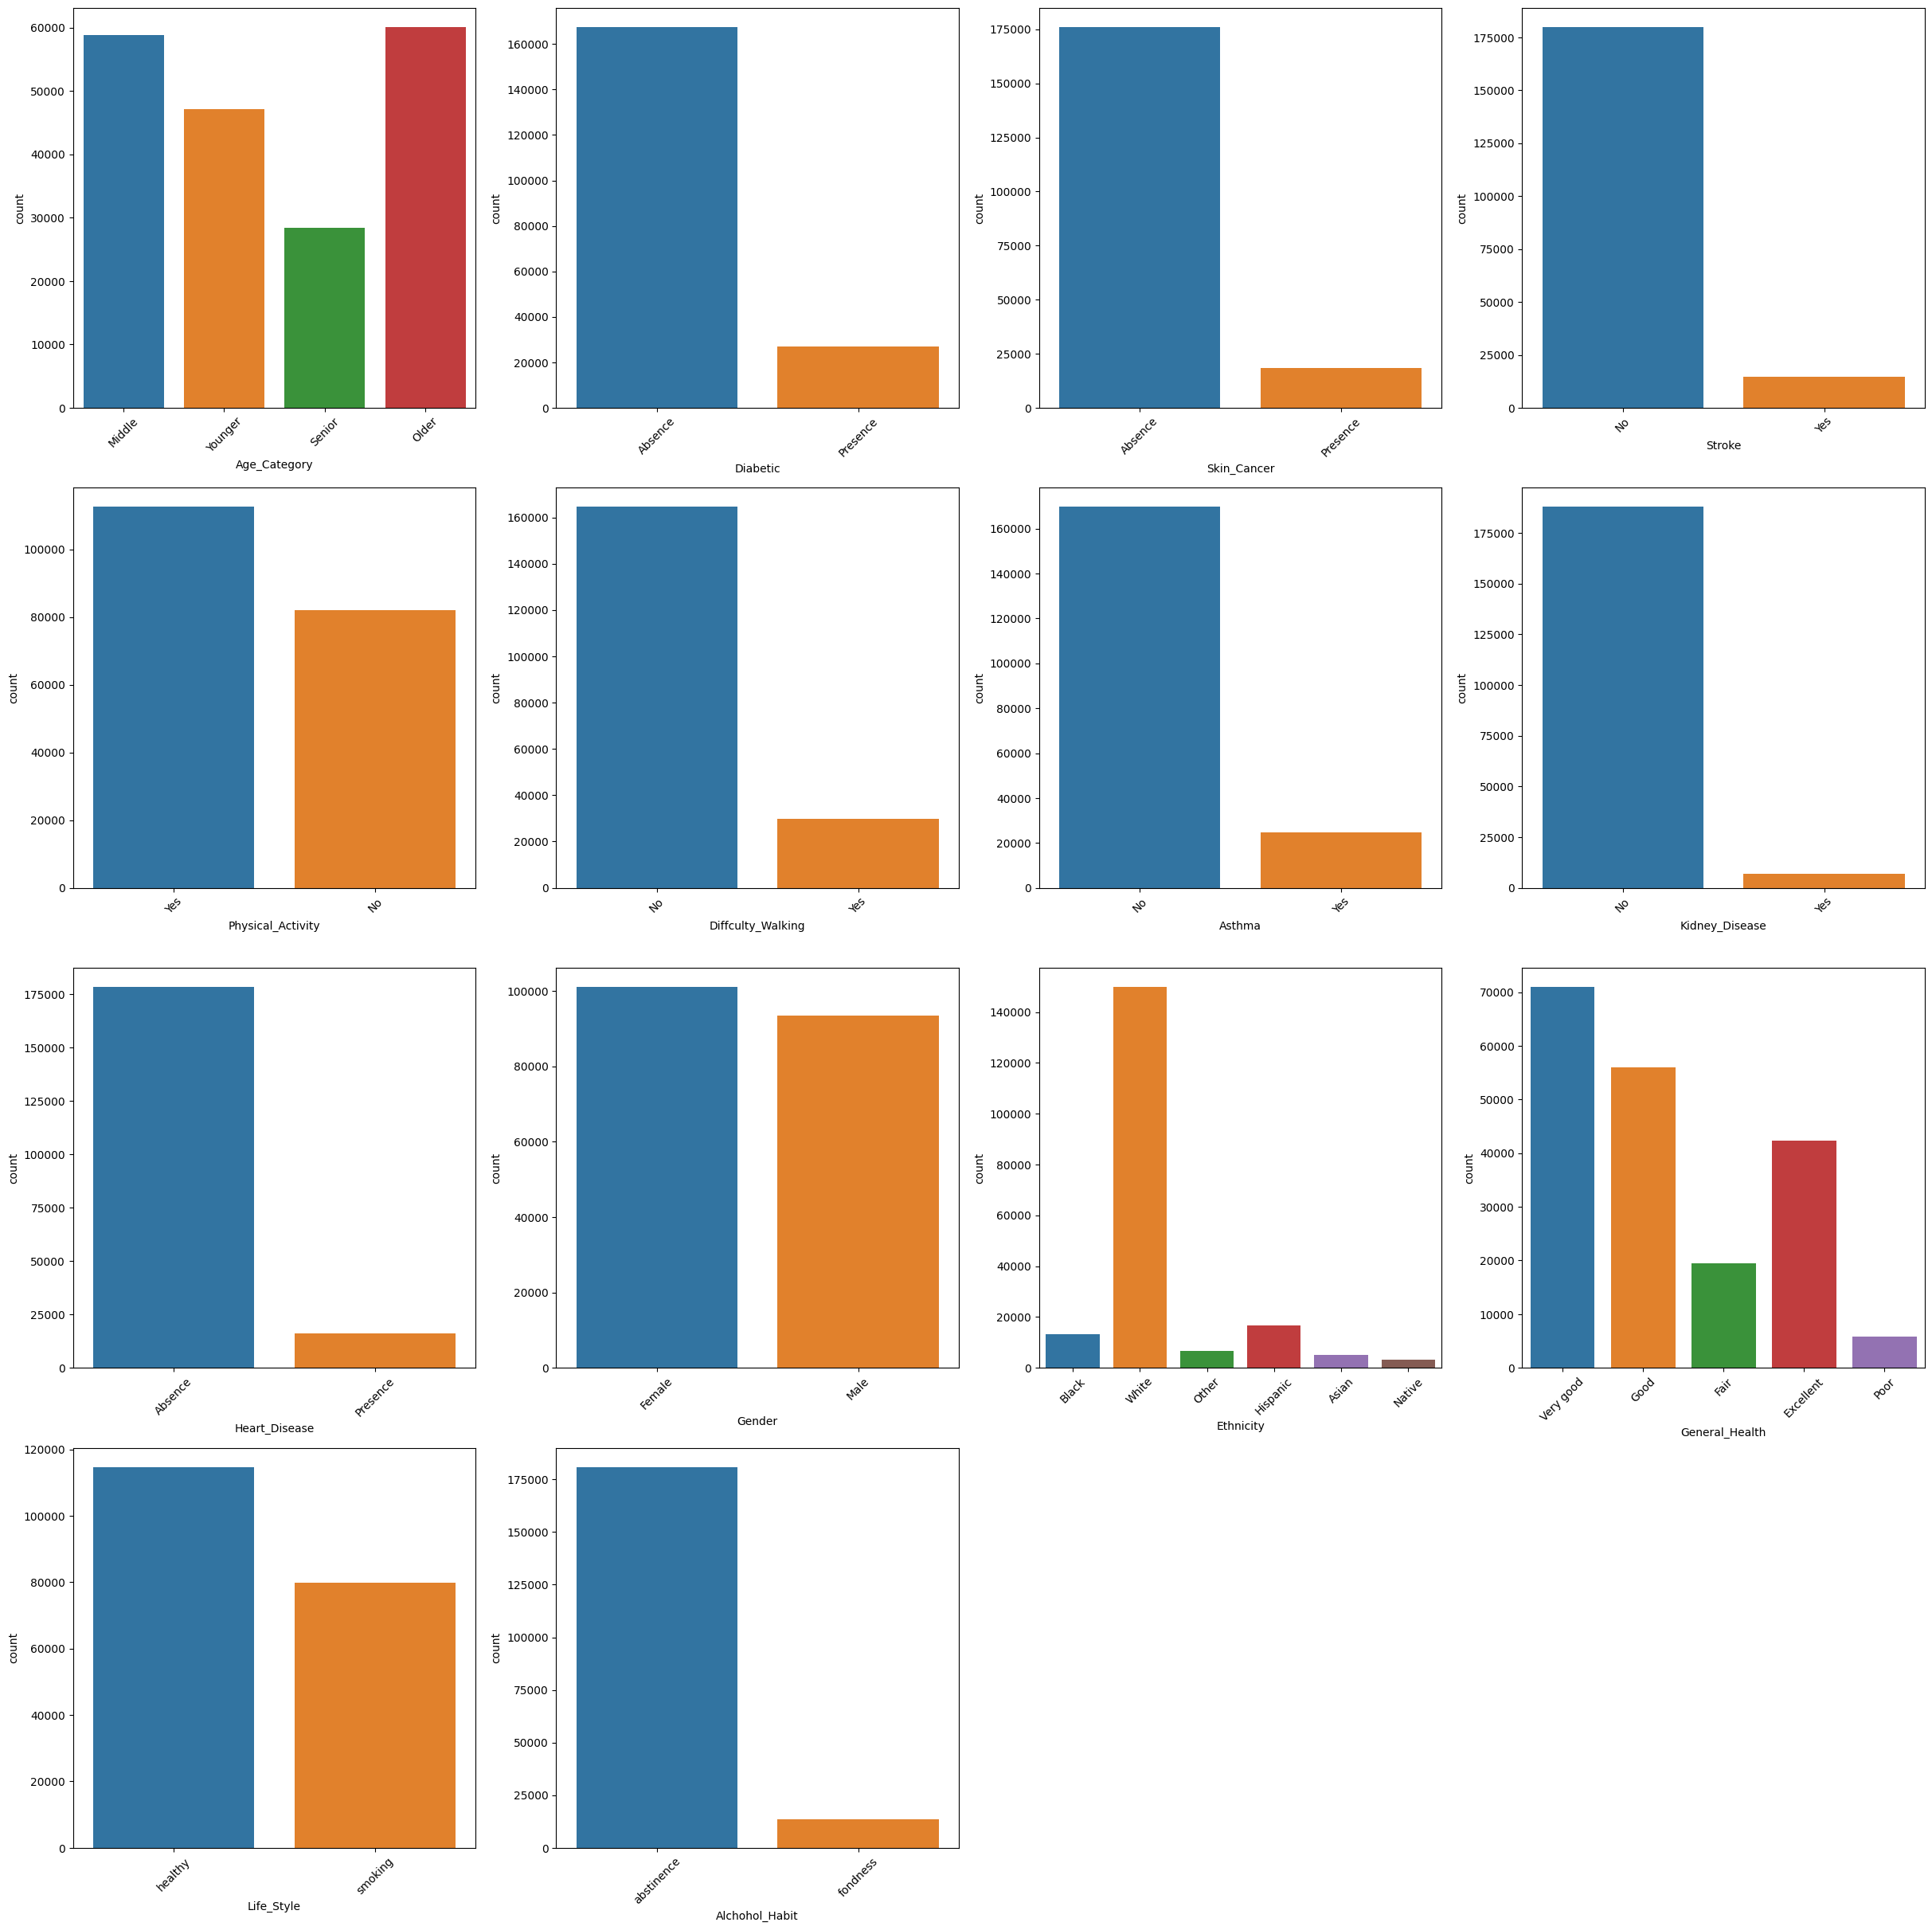

In [32]:
fig = plt.figure(figsize=(30,30))

counter = 0

for i in df.columns:
    if df[i].dtype == 'object':
        sub = fig.add_subplot(4,4,counter+1)
        g = sns.countplot(x=i,data=df)
        plt.xticks(rotation=45)
        counter = counter + 1

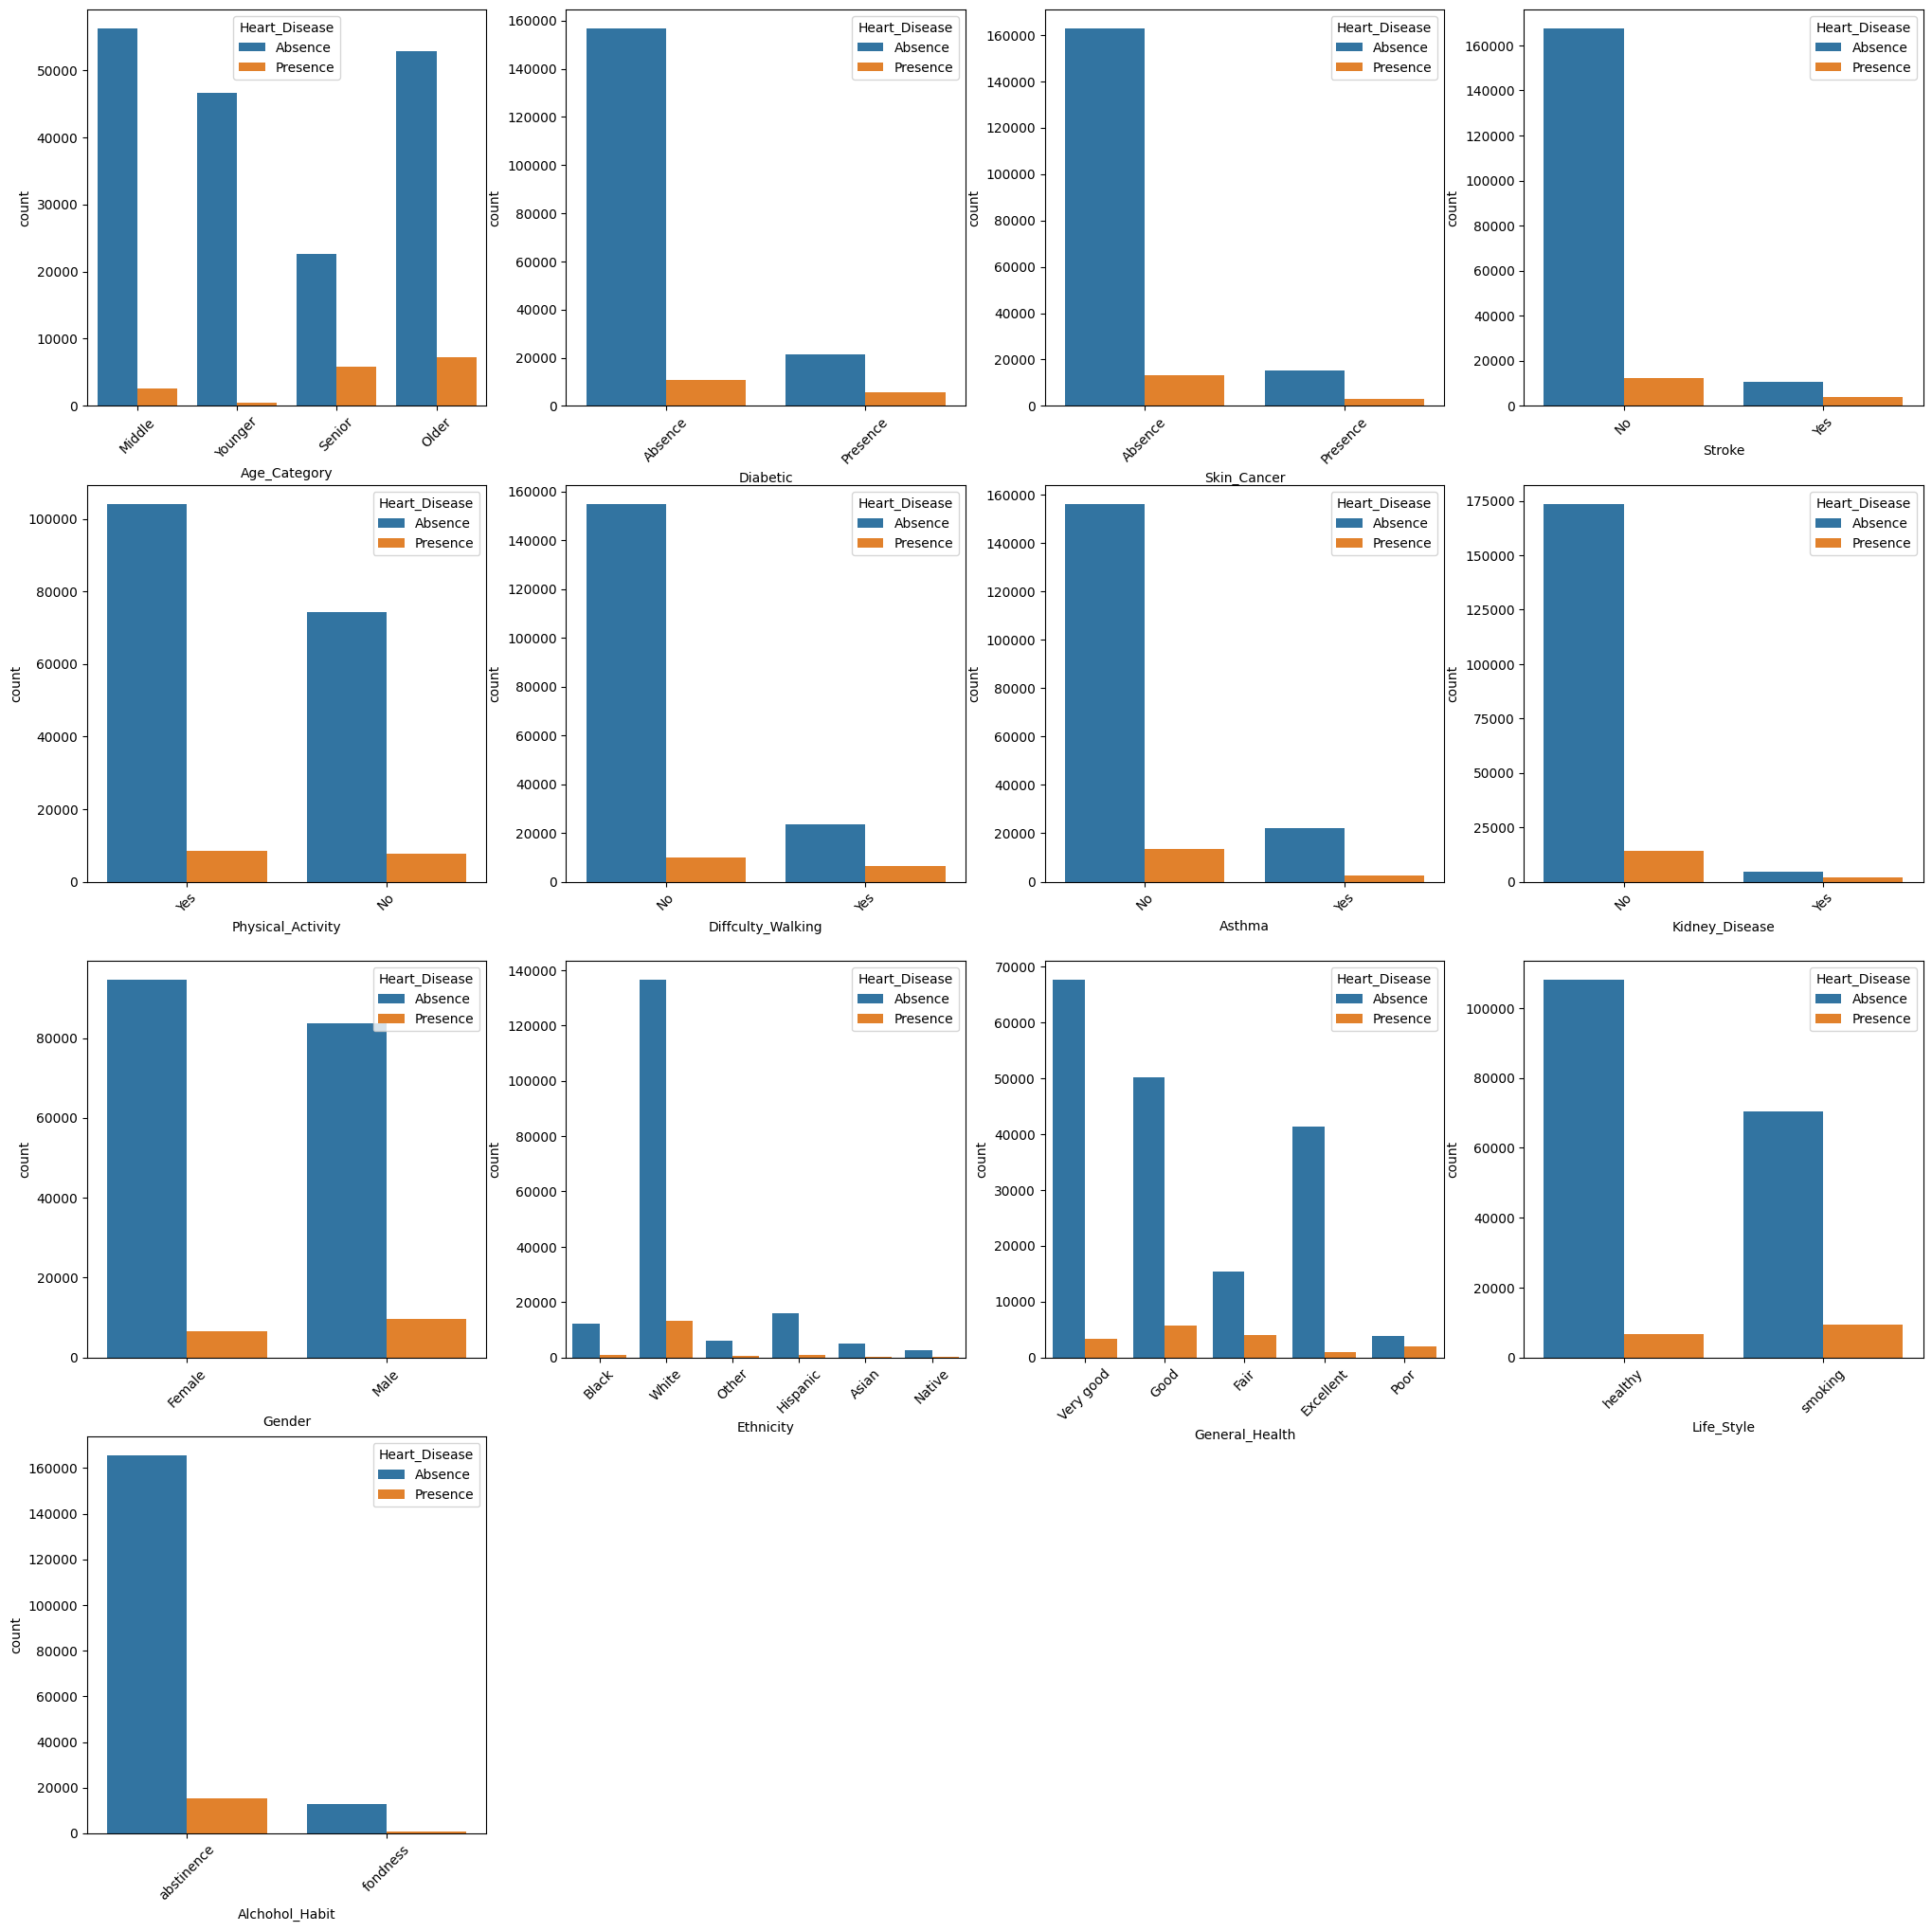

In [33]:
fig = plt.figure(figsize=(25,25))

counter = 0

for i in df.columns:
    if df[i].dtype == 'object' and i != 'Heart_Disease':
        sub = fig.add_subplot(4,4,counter+1)
        g = sns.countplot(x=i,data=df,hue='Heart_Disease')
        plt.xticks(rotation=45)
        counter += 1

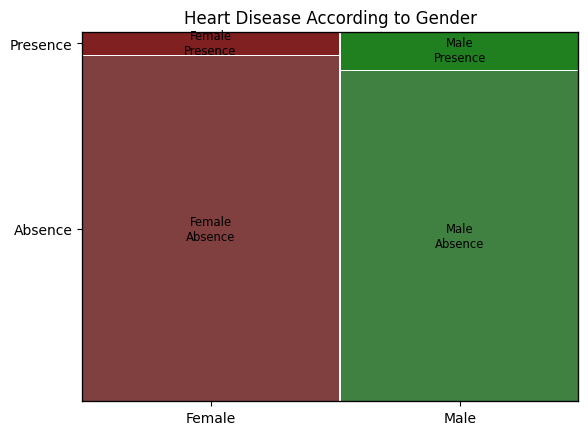

In [34]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic = mosaic(df, ['Gender', 'Heart_Disease'], title="Heart Disease According to Gender")
plt.show()

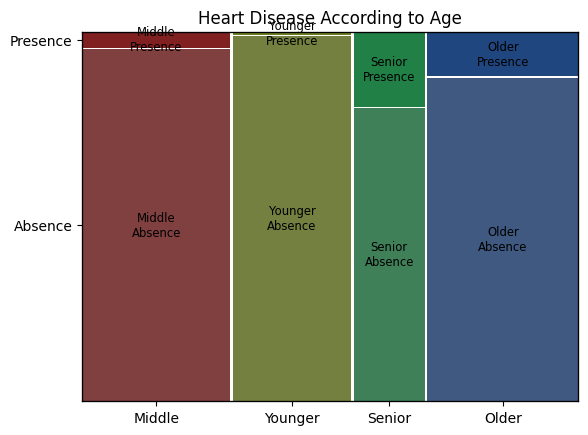

In [35]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic = mosaic(df,['Age_Category', 'Heart_Disease'], title="Heart Disease According to Age")
plt.show()

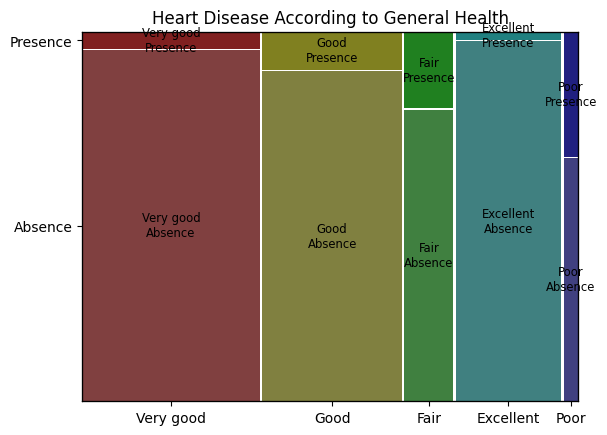

In [36]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic = mosaic(df,['General_Health', 'Heart_Disease'], title="Heart Disease According to General Health")
plt.show()

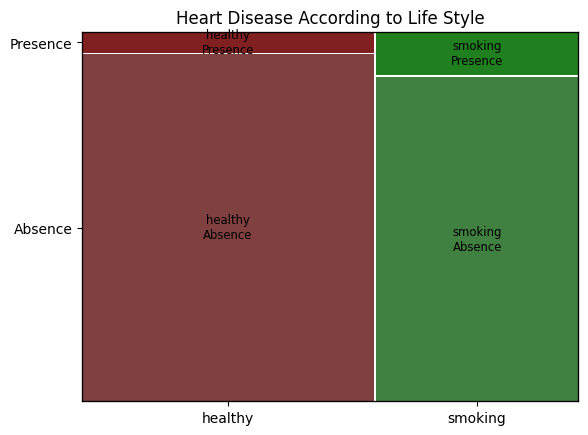

In [37]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic = mosaic(df,['Life_Style', 'Heart_Disease'], title="Heart Disease According to Life Style")
plt.show()

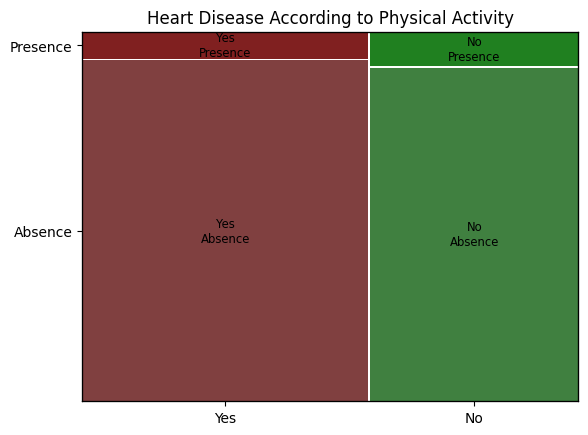

In [38]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic = mosaic(df,['Physical_Activity', 'Heart_Disease'], title="Heart Disease According to Physical Activity")
plt.show()

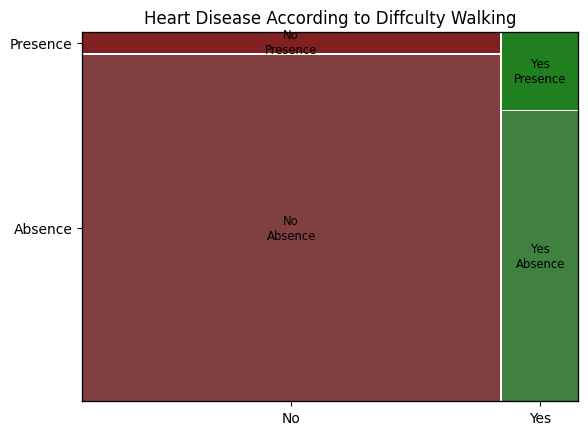

In [39]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic = mosaic(df,['Diffculty_Walking', 'Heart_Disease'], title="Heart Disease According to Diffculty Walking")
plt.show()

### Insights
- `Male` people that has `Heart Disease` are larger than `Female` ones.
- `Older` and `Senior` people in `Age Category` Column that has `Heart Disease` are the largest ones.
- People with `Poor` and `Fair` in `General Health ` Column that has `Heart Disease` are the largest ones.
- People with `Smoking` habit are exposed to have `Heart Disease`
- People with `No` `Physical Activity` has more `Heart Disease`
- People with `Diffculty Walking` has more `Heart Disease`

<a name="5"></a>
## 5 - Feature Selection using Feature Importance
   - we need to choose the best features which have great correaltion with our target column 

### - Encoding Categorical Columns

In [72]:
enc_cols = ['Age_Category','Diabetic','Skin_Cancer','Stroke',"Physical_Activity", "Diffculty_Walking"
            , "Asthma", "Kidney_Disease", "Gender", "General_Health","Life_Style","Alchohol_Habit", 'Ethnicity']

In [41]:
encoder = OrdinalEncoder()
df[enc_cols] = encoder.fit_transform(df[enc_cols])
encoder.categories_

[array(['Middle', 'Older', 'Senior', 'Younger'], dtype=object),
 array(['Absence', 'Presence'], dtype=object),
 array(['Absence', 'Presence'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Excellent', 'Fair', 'Good', 'Poor', 'Very good'], dtype=object),
 array(['healthy', 'smoking'], dtype=object),
 array(['abstinence', 'fondness'], dtype=object),
 array(['Asian', 'Black', 'Hispanic', 'Native', 'Other', 'White'],
       dtype=object)]

### - Encoding Target Variable `Heart_Disease` Column

In [42]:
enc_y = LabelEncoder()
y = df['Heart_Disease']
y = enc_y.fit_transform(y)
df["Heart_Disease"] = enc_y.fit_transform(y)

In [43]:
enc_y.classes_

array([0, 1])

In [44]:
y

array([0, 0, 0, ..., 0, 0, 0])

### - Scaling Numerical Columns

In [45]:
num_cols = ['BMI',"Time_Of_Sleep","Physical_Health", "Mental_Health"]
sc = StandardScaler()
df[num_cols] = sc.fit_transform(df[num_cols])

### - Feature Importance

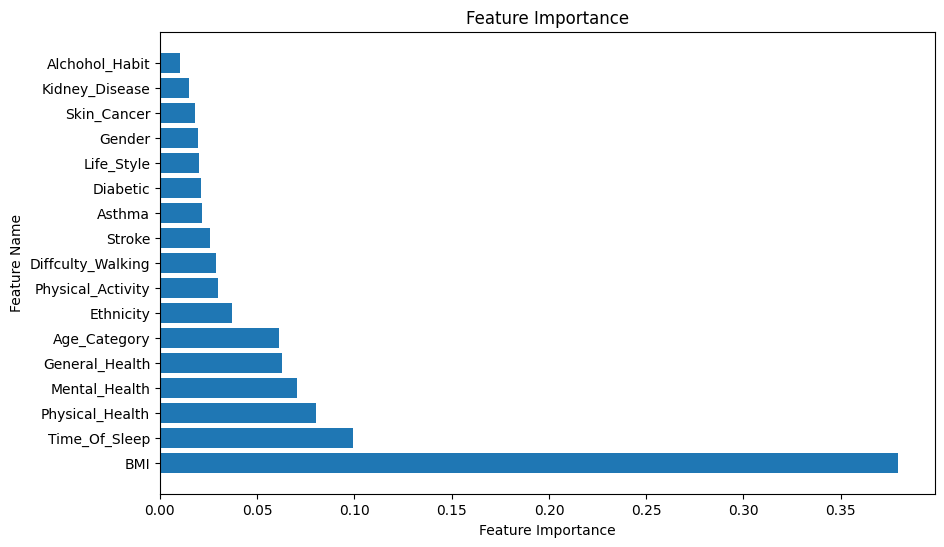

In [46]:
X = df.drop(columns=["Heart_Disease","ID"])
y = df["Heart_Disease"]

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a Random Forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

feature_importance = model.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

### Summary
- The most important features are `BMI`, `Time_Of_Sleep`, `Physical_Health`, `Mental_Health`, `General_Health`
- It will be better not to choose features like `Alchohol_habit`, `Kidney_Disease`, `Skin_Cancer`

<a name="6"></a>
## 6 - Modeling

<a name="6.1"></a>
### 6.1 - Random Forest Classifier

In [47]:
X = df.drop(columns=["Heart_Disease", "ID","Kidney_Disease", "Alchohol_Habit","Skin_Cancer", "Asthma"])
y = df["Heart_Disease"]

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Raandom Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=50, criterion='log_loss')

# Fit(Train) Model
rf_model.fit(X_train,y_train)

# Make Predictions
rf_predtions = rf_model.predict(X_test)

In [48]:
logloss = log_loss(y_test, rf_model.predict_proba(X_test))
print("log loss score:", logloss)

log loss score: 0.6360587739943188


In [49]:
accuracy = accuracy_score(y_test, rf_predtions)
print("Accuracy:", accuracy)

Accuracy: 0.9033728662507713


<a name="6.1.1"></a>
### 6.1.1 - Random Forest Tuned Model

In [50]:
# rf_tune = RandomForestClassifier(random_state= 42 ,max_depth = 100, min_samples_split= 20, n_estimators = 400,
#                                 min_samples_leaf=30, bootstrap= True, criterion="log_loss")

rf_tune = RandomForestClassifier(random_state=42, n_estimators= 300, min_samples_split= 20,
                                 min_samples_leaf= 30, max_depth= 140, bootstrap= True, criterion="log_loss")


# rf_tune = RandomForestClassifier(random_state= 42 ,max_depth = 30, min_samples_split= 10, n_estimators = 50,
#                                 min_samples_leaf=2, bootstrap= True)

rf_tune.fit(X_train,y_train)

rf_tune_predictions = rf_tune.predict(X_test)

logloss = log_loss(y_test, rf_tune.predict_proba(X_test))
print("log loss score:", logloss)

log loss score: 0.22632094766869978


In [51]:
accuracy = accuracy_score(y_test, rf_tune_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.917940632069651


### Using RandomizedSearch to tune our model

In [52]:
rf_param_dist = {
    'n_estimators': range(100, 500, 50),
    'max_depth': range(30, 200, 10),
    'min_samples_split': range(5, 40, 5),
    'min_samples_leaf': range(5, 40, 5),
    'bootstrap': [True, False]
}

In [53]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=rf_param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='accuracy', 
    cv=5,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(criterion='log_loss',
                                                    max_depth=140,
                                                    min_samples_leaf=30,
                                                    min_samples_split=20,
                                                    n_estimators=300,
                                                    random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(30, 200, 10),
                                        'min_samples_leaf': range(5, 40, 5),
                                        'min_samples_split': range(5, 40, 5),
                                        'n_estimators': range(100, 500, 50)},
                   random_state=42, scoring='accuracy', verbose=1)

In [54]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Model Score:", best_model.score(X_test, y_test))

Best Parameters: {'n_estimators': 400, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_depth': 40, 'bootstrap': False}
Best Model Score: 0.9180777404538287


<a name="6.2"></a>
### 6.2 - XGBoost Classifier

In [55]:
# XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

logloss = log_loss(y_test, xgb_model.predict_proba(X_test))
print("log loss score:", logloss)

log loss score: 0.22867884965977253


In [56]:
accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9164667169397409


### XGBoost Model Tunning Using RandomizedSearch

In [57]:
xgb_param_dist = {
    'n_estimators': range(20,250),
    'max_depth': range(30,100),
}

In [58]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='f1_macro',  # Use appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   param_distributions={'max_depth': range(30, 100),
                                        'n_estimators': range(20, 250)},
                   random_state=42, scoring='f1_macro', verbose=1)

In [59]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Model Score:", best_model.score(X_test, y_test))

Best Parameters: {'n_estimators': 160, 'max_depth': 61}
Best Model Score: 0.9014362103242614


<a name="6.2.1"></a>
### 6.2.1 - XGBoost Tuned Model

In [60]:
xgb_tune = XGBClassifier(random_state=42, n_estimators= 50, max_depth= 30)

xgb_tune.fit(X_train, y_train)

xgb_tune_predictions = xgb_tune.predict(X_test)

logloss = log_loss(y_test, xgb_tune.predict_proba(X_test))
print("log loss score:", logloss)

log loss score: 0.28944100040627596


In [61]:
accuracy = accuracy_score(y_test, xgb_tune_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9073832864879687


### Summary
- Between the two models, we found that:
    - `Random Forest Classifier` has higher acuuracy and low loss than `XGBoost Classifier`. so, We will complete with it.
    - After Tunning our models, Accuracy is increased and Loss is decreased

<a name="7"></a>
## - 7 Loading Test Data
- We will do Same process that we have done before

In [62]:
df_test = pd.read_csv("/kaggle/input/heart-disease/Data/test_data.csv")

In [63]:
df_test.head()

,ID,Person_Story,Age_Category,BMI,DiabeticORABS,SkinCancerORABS,Stroke,PhysicalHealth,MentalHealth,PhysicalActivity,DiffWalking,TImEOFSLeeP,Asthma,KidneyDisease
0,0,"Once upon a time, there was a Female person of...",Middle,23.57,Absence,Absence,No,0,0,Yes,No,7,No,No
1,1,"Once upon a time, there was a Male person of W...",Younger,31.38,Absence,Absence,NaN,1,10,Yes,NaN,8,No,No
2,2,"Once upon a time, there was a Male person of W...",Middle,30.17,Absence,Absence,No,0,4,NaN,No,8,No,No
3,3,"Once upon a time, there was a Male person of W...",Older,31.46,Presence,Absence,No,10,0,NaN,No,5,Yes,Yes
4,4,"Once upon a time, there was a Male person of W...",Older,25.77,Absence,Absence,No,0,0,NaN,No,7,No,No


In [64]:
df_test = df_test.rename(columns = {"DiabeticORABS" : "Diabetic", "SkinCancerORABS" : "Skin_Cancer",
                "PhysicalHealth" : "Physical_Health", "MentalHealth" : "Mental_Health",
               "PhysicalActivity" : "Physical_Activity", "TImEOFSLeeP" : "Time_Of_Sleep",
               "KidneyDisease" : "Kidney_Disease", "HeartDisease" : "Heart_Disease",
               "DiffWalking" : "Diffculty_Walking"})

In [65]:
df_test["Diabetic"] = df_test["Diabetic"].replace({"Yes (during pregnancy)":"Absence",
                                                   "No, borderline diabetes":"Presence"})

In [66]:
df_test.columns

Index(['ID', 'Person_Story', 'Age_Category', 'BMI', 'Diabetic', 'Skin_Cancer',
       'Stroke', 'Physical_Health', 'Mental_Health', 'Physical_Activity',
       'Diffculty_Walking', 'Time_Of_Sleep', 'Asthma', 'Kidney_Disease'],
      dtype='object')

In [67]:
gender_pattern = r'(Male|Female)'
ethnicity_pattern = r'(\w+) ethnicity'
health_condition_pattern = r'general health condition was described as \'([^\']+)\''
lifestyle_pattern = r'known for their (\w+)'
alcohol_habit_pattern = r'(abstinence|fondness)'

df_test['Gender'] = df_test['Person_Story'].str.extract(gender_pattern, flags=re.IGNORECASE)
df_test['Ethnicity'] = df_test['Person_Story'].str.extract(ethnicity_pattern)
df_test['General_Health'] = df_test['Person_Story'].str.extract(health_condition_pattern)
df_test['Life_Style'] = df_test['Person_Story'].str.extract(lifestyle_pattern)
df_test["Alchohol_Habit"] = df_test['Person_Story'].str.extract(alcohol_habit_pattern)

In [68]:
df_test = df_test.drop(columns=["Person_Story"])

In [69]:
df_test["Stroke"] = df_test["Stroke"].fillna(df_test['Diabetic'])
df_test["Physical_Activity"] = df_test['Physical_Activity'].fillna(df_test['Diabetic'])
df_test["Diffculty_Walking"] = df_test['Diffculty_Walking'].fillna(df_test['Diabetic'])

df_test["Stroke"] = df_test["Stroke"].replace({"Presence":"Yes", "Absence":"No"})
df_test["Physical_Activity"] = df_test["Physical_Activity"].replace({"Presence":"Yes", "Absence":"No"})
df_test["Diffculty_Walking"] = df_test["Diffculty_Walking"].replace({"Presence":"Yes", "Absence":"No"})

In [73]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
df_test[enc_cols] = encoder.transform(df_test[enc_cols])
encoder.categories_

[array(['Middle', 'Older', 'Senior', 'Younger'], dtype=object),
 array(['Absence', 'Presence'], dtype=object),
 array(['Absence', 'Presence'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Excellent', 'Fair', 'Good', 'Poor', 'Very good'], dtype=object),
 array(['healthy', 'smoking'], dtype=object),
 array(['abstinence', 'fondness'], dtype=object),
 array(['Asian', 'Black', 'Hispanic', 'Native', 'Other', 'White'],
       dtype=object)]

In [74]:
num_cols = ['BMI',"Time_Of_Sleep",'Physical_Health', 'Mental_Health']
df_test[num_cols] = sc.transform(df_test[num_cols])

In [75]:
preds = rf_tune.predict(df_test.drop(columns=["ID","Alchohol_Habit","Kidney_Disease","Asthma",
                                              "Skin_Cancer"]))
preds

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
df_submission = df_test
df_submission["Heart_Disease"] = preds
df_submission = df_submission.drop(columns=['Age_Category', 'BMI', 'Diabetic', 'Skin_Cancer', 'Stroke'
                               , 'Physical_Activity','Diffculty_Walking','Time_Of_Sleep','Physical_Health',
                                'Mental_Health','Asthma', 'Kidney_Disease', 'Gender','Ethnicity', 'General_Health',
                           'Life_Style', 'Alchohol_Habit'], axis = 1)
df_submission.head()

,ID,Heart_Disease
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [77]:
df_submission["Heart_Disease"].value_counts()

Heart_Disease
0    111550
1       216
Name: count, dtype: int64

In [78]:
y_test.shape

(58348,)

In [79]:
accuracy = accuracy_score(y_test, preds[:y_test.shape[0]])
print("Accuracy:", accuracy)

Accuracy: 0.9154898197024748


In [80]:
df_submission.to_csv("SubmissionFinal.csv", index = False)

# End